# BASIC CONFIGURATIONS

In [7]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [8]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 2 days, 18:14:02
GitHash      = 0xec4bbe1aacb7b25264643ab12c2af8743df8d3f8
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Mon 14 Aug 2023 01:21:34 PM PDT
Builder      = dnajjar
###################################################


In [9]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac

In [10]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [11]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor

# Helper functions

In [12]:
def enableAllAsics(enable) :
    BATCHER0.Blowoff.set(not enable)
    BATCHER1.Blowoff.set(not enable)
    BATCHER2.Blowoff.set(not enable)
    BATCHER3.Blowoff.set(not enable)
    
def enableAsic(batcherIndex, enable) :
    getattr(root.App.AsicTop, f"BatcherEventBuilder{batcherIndex}").Blowoff.set(not enable)    
    
# Helper functions

def disableAndCleanAllFullRateDataRcv() :
    FULLRATERCV0.cleanData()
    FULLRATERCV1.cleanData()
    FULLRATERCV2.cleanData()
    FULLRATERCV3.cleanData()
    FULLRATERCV0.RxEnable.set(False)
    FULLRATERCV1.RxEnable.set(False)
    FULLRATERCV2.RxEnable.set(False)
    FULLRATERCV3.RxEnable.set(False)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)
    
    
def enableDataRcv(enable) :
    DATARCV0.RxEnable.set(enable)
    DATARCV1.RxEnable.set(enable)
    DATARCV2.RxEnable.set(enable)
    DATARCV3.RxEnable.set(enable)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)    

In [13]:
def hwTrigger(frames, rate) :
    # precaution in case someone stops the acquire function in the middle
    TRIG.StopTriggers() 
    
    TRIG.AcqCountReset()
    TRIG.SetAutoTrigger(rate)
    TRIG.numberTrigger.set(frames)
    TRIG.StartAutoTrigger()
    
    # Wait for the file write to write the 10 waveforms
    while (TRIG.AcqCount.get() != frames) :
        print("Triggers sent: {}".format(TRIG.AcqCount.get()) , end='\r')
        time.sleep(0.1)
    print("Triggers sent: {}".format(TRIG.AcqCount.get()))
    
    # stops triggers
    TRIG.StopTriggers()  

In [14]:
def getLaneLocks() :
    for asicIndex in range(4) : 
        root.App.SspMonGrp[asicIndex].enable.set(True)
        print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

In [15]:
#check current frames in receivers
def printDataReceiverStatus() :
    for asicIndex in range(4):
        print("Checkpoint: DataReceiver {} has {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

# Disable full rate receivers for now

In [16]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableAllAsics(False)
root.enableAsic(3, True)
DEBUG3.enableDataDebug(True)
DEBUG3.cleanData()

# Lorenzo - Helper functions

In [17]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# ADC Response with external DAC single writes

In [18]:
ASIC3.mTest.set(True)  # Enable external DAC
ASIC3.DHg.set(True)    # Set High gain
ASIC3.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC3.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC3.RefGenB.set(2)   # Don't touch

In [20]:
# Set minimum and maximum values for DAC scan

DAC_minValue=0
DAC_maxValue=548575
DAC_step=10000
DAC_framesForEachStep=16

iterations = len(range(DAC_minValue, DAC_maxValue, DAC_step))

dataScan = np.empty((192,384,iterations))
DACScan  = np.empty(iterations)

#write to DAC

for i, DACValue in enumerate(range(DAC_minValue,DAC_maxValue,DAC_step)):
    print('Iteration {}/{}'.format(i,iterations))
    DAC.FastDac.DacValue.set(DACValue)
#     print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))
    DACScan[i] = DAC.FastDac.DacValueV.get()
    
    # Get data
    dataTemp = readoutFrames(DAC_framesForEachStep)
    dataTemp = np.median(dataTemp, axis=2) 
    dataScan[:,:,i] = dataTemp

Iteration 0/55
Data Descrambled
(192, 384, 16)
Iteration 1/55
Data Descrambled
(192, 384, 16)
Iteration 2/55
Data Descrambled
(192, 384, 16)
Iteration 3/55
Data Descrambled
(192, 384, 16)
Iteration 4/55
Data Descrambled
(192, 384, 16)
Iteration 5/55
Data Descrambled
(192, 384, 16)
Iteration 6/55
Data Descrambled
(192, 384, 16)
Iteration 7/55
Data Descrambled
(192, 384, 16)
Iteration 8/55
Data Descrambled
(192, 384, 16)
Iteration 9/55
Data Descrambled
(192, 384, 16)
Iteration 10/55
Data Descrambled
(192, 384, 16)
Iteration 11/55
Data Descrambled
(192, 384, 16)
Iteration 12/55
Data Descrambled
(192, 384, 16)
Iteration 13/55
Data Descrambled
(192, 384, 16)
Iteration 14/55
Data Descrambled
(192, 384, 16)
Iteration 15/55
Data Descrambled
(192, 384, 16)
Iteration 16/55
Data Descrambled
(192, 384, 16)
Iteration 17/55
Data Descrambled
(192, 384, 16)
Iteration 18/55
Data Descrambled
(192, 384, 16)
Iteration 19/55
Data Descrambled
(192, 384, 16)
Iteration 20/55
Data Descrambled
(192, 384, 16)
It

# ChatGPT linear regression

In [21]:
from scipy.stats import linregress

x = DACScan
y = dataScan[0,383,:]


linear_ranges = []
min_points_in_range = 10  # Minimum number of points in a range for consideration

for i in range(len(x) - min_points_in_range + 1):
    for j in range(i + min_points_in_range, len(x) + 1):
        x_range = x[i:j]
        y_range = y[i:j]
        
        if len(x_range) >= min_points_in_range:
            slope, intercept, r_value, p_value, std_err = linregress(x_range, y_range)
            linear_ranges.append({
                'start_index': i,
                'end_index': j - 1,
                'r_squared': r_value ** 2,
                'slope': slope,
                'intercept': intercept
            })

linear_ranges.sort(key=lambda x: x['r_squared'], reverse=True)

best_linear_range = linear_ranges[0]
start_index = best_linear_range['start_index']
end_index = best_linear_range['end_index']

gain = best_linear_range['slope']
offset = best_linear_range['intercept']


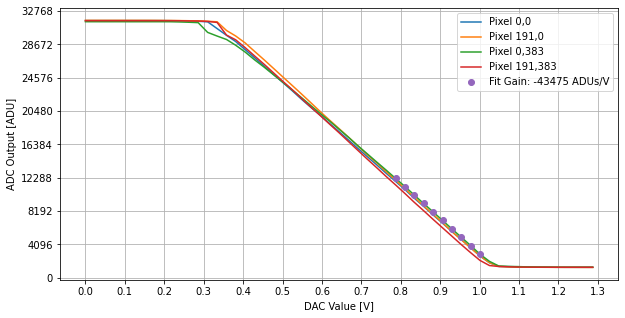

In [22]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize = (10,5))

plt.plot(DACScan,dataScan[0,0,:], label='Pixel 0,0')
plt.plot(DACScan,dataScan[191,0,:], label='Pixel 191,0')
plt.plot(DACScan,dataScan[0,383,:], label='Pixel 0,383')
plt.plot(DACScan,dataScan[191,383,:], label='Pixel 191,383')

plt.plot(x[start_index:end_index+1], best_linear_range['slope'] * x[start_index:end_index+1] + best_linear_range['intercept'], 'o', label='Fit Gain: {:.0f} ADUs/V'.format(gain))

plt.legend()



ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(4096))
plt.grid(True)

ax.set_ylabel('ADC Output [ADU]')
ax.set_xlabel('DAC Value [V]')


# Show the plots
plt.show()



# Check Pixel range

In [24]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(6)
ASIC3.RefinP.set(1)

ASIC3.RefinN.set(6)
ASIC3.RefinP.set(0)


plt.figure(figsize = (10,5))


# Get ramps and calculate gain
ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=0,Max=400,numSteps=10)



Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)


<Figure size 720x360 with 0 Axes>

Noise:-0.000690059188183481


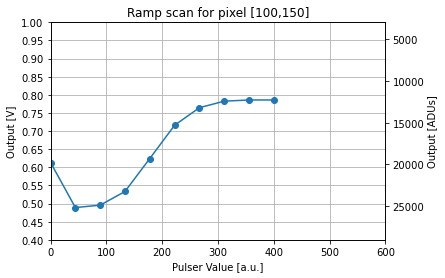

In [25]:
plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='{}/{}')
plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim(0.4, 1.0)  # Set y axis limits from -1 to 1

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.plot(ChInjValues, -1*PixOutValues)

plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim((0.4*gain+offset), (1.0*gain+offset))  # Set y axis limits from -1 to 1

plt.ylabel("Output [ADUs]")




plt.title('Ramp scan for pixel [{},{}]'.format(ref_row,ref_col))
ax.grid(True)

print('Noise:{}'.format(30/gain))

RefinP = 0
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 1
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 2
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinP = 3
Data Descrambled
(192, 384

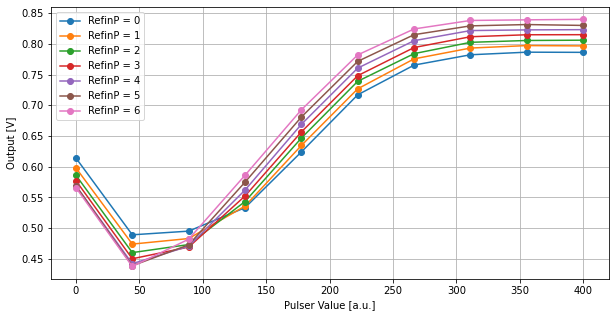

In [26]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(6)
ASIC3.RefinP.set(1)

plt.figure(figsize = (10,5))

for RefinPValue in range(7):
    print('RefinP = {}'.format(RefinPValue))
    ASIC3.RefinP.set(RefinPValue)
    # Get ramps and calculate gain
    ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=0,Max=400,numSteps=10)
    plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='RefinP = {}'.format(RefinPValue))

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")
ax = plt.gca()
ax.grid(True)

plt.legend()


RefinN = 0
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinN = 1
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinN = 2
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
RefinN = 3
Data Descrambled
(192, 384

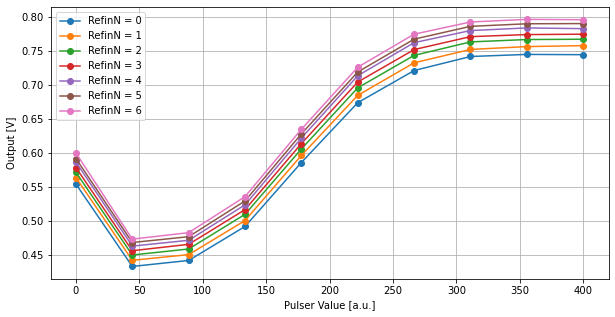

In [27]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
ASIC3.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC3.RefinN.set(6)
ASIC3.RefinP.set(1)

plt.figure(figsize = (10,5))

for RefinNValue in range(7):
    print('RefinN = {}'.format(RefinNValue))
    ASIC3.RefinN.set(RefinNValue)
    # Get ramps and calculate gain
    ChInjValues, PixOutValues = ChInjRamp(numberOfTriggers=3,Min=0,Max=400,numSteps=10)
    plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='RefinN = {}'.format(RefinNValue))

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")
ax = plt.gca()
ax.grid(True)

plt.legend()
